In [1]:
import pandas as pd
from google.cloud import bigquery

# hg19

In [2]:
pd.read_csv(
    "gs://gdc-tcga-phs000178-open/0b8b258e-1671-4f86-82e7-59b12ad40d9c/unc.edu.4c243ea9-dfe1-42f0-a887-3c901fb38542.2477720.rsem.genes.results",
    sep="\t",
)

,gene_id,raw_count,scaled_estimate,transcript_id
0,?|100130426,0.00,0.000000e+00,uc011lsn.1
1,?|100133144,11.07,2.887527e-07,"uc010unu.1,uc010uoa.1"
2,?|100134869,15.93,3.024025e-07,"uc002bgz.2,uc002bic.2"
3,?|10357,355.48,2.085068e-05,uc010zzl.1
4,?|10431,3032.00,8.241796e-05,"uc001jiu.2,uc010qhg.1"
...,...,...,...,...
20526,ZYX|7791,3061.00,4.357639e-05,"uc003wcw.2,uc003wcx.2,uc011ktd.1,uc011kte.1,uc..."
20527,ZZEF1|23140,1542.00,3.959755e-06,"uc002fxe.2,uc002fxg.1,uc002fxh.2,uc002fxi.2,uc..."
20528,ZZZ3|26009,1786.00,1.620152e-05,"uc001dhp.2,uc001dhq.2,uc001dhr.2,uc009wbz.1"
20529,psiTPTE22|387590,7.00,1.537329e-07,"uc002zlq.3,uc002zlr.2,uc002zls.1,uc002zlt.2,uc..."


# hg38

In [44]:
%%time
df = pd.read_csv(
    "gs://gdc-tcga-phs000178-open/6f0f09df-cb9e-4ee6-9f0d-e0c7bb2aa001/9cc93369-3cc7-4293-9f42-a997c26243c9.FPKM.txt.gz",
    sep="\t",
    # header=None,
    names=["gene_id_and_version", "FPKM"],
    # index_col=0,
)
# df = df.set_index(pd.MultiIndex.from_tuples(df.index.str.split(".").tolist(), names=["gene_id", "gene_version"]))
df[["gene_id", "gene_version"]] = df["gene_id_and_version"].str.split(
    ".", 1, expand=True
)
df

CPU times: user 252 ms, sys: 1.59 ms, total: 254 ms
Wall time: 331 ms


,gene_id_and_version,FPKM,gene_id,gene_version
0,ENSG00000242268.2,0.000000,ENSG00000242268,2
1,ENSG00000270112.3,0.000000,ENSG00000270112,3
2,ENSG00000167578.15,6.891068,ENSG00000167578,15
3,ENSG00000273842.1,0.000000,ENSG00000273842,1
4,ENSG00000078237.5,8.628685,ENSG00000078237,5
...,...,...,...,...
60478,ENSG00000105063.17,17.687587,ENSG00000105063,17
60479,ENSG00000231119.2,0.082573,ENSG00000231119,2
60480,ENSG00000280861.1,0.000000,ENSG00000280861,1
60481,ENSG00000123685.7,1.328293,ENSG00000123685,7


## get gene names of gene IDs from bigquery

In [25]:
bq_client = bigquery.Client()

In [26]:
query_string = """
select
    gene_biotype,
    gene_name,
    gene_id,
    gene_version,
    CONCAT(gene_id, ".", gene_version) as gene_id_and_version,
    count(*) as count_rows
from `isb-cgc.genome_reference.Ensembl_GRCh38_87`
--where gene_biotype = "protein_coding"
group by 1,2,3,4,5
order by 1, 2, 3
"""

gene_id_names = bq_client.query(query_string).to_dataframe(progress_bar_type="tqdm")

Downloading: 100%|██████████| 58051/58051 [00:01<00:00, 44630.40rows/s]


In [32]:
gene_id_names.query("gene_biotype == 'protein_coding'")[
    "gene_name"
].value_counts().value_counts().sort_values(ascending=False)

1    19905
2       28
Name: gene_name, dtype: int64

In [45]:
gene_id_names.sample(10)

,gene_biotype,gene_name,gene_id,gene_version,gene_id_and_version,count_rows
30420,protein_coding,ANKRD13A,ENSG00000076513,16,ENSG00000076513.16,135
15306,miRNA,MIR381,ENSG00000199020,3,ENSG00000199020.3,3
29999,protein_coding,ADGRF3,ENSG00000173567,14,ENSG00000173567.14,179
36775,protein_coding,H2BFS,ENSG00000234289,5,ENSG00000234289.5,8
38513,protein_coding,LAIR2,ENSG00000167618,9,ENSG00000167618.9,45
10471,lincRNA,RP11-103C3.1,ENSG00000232436,1,ENSG00000232436.1,4
10209,lincRNA,PCAT18,ENSG00000265369,3,ENSG00000265369.3,4
11250,lincRNA,RP11-218F4.1,ENSG00000260019,1,ENSG00000260019.1,6
35447,protein_coding,FANCE,ENSG00000112039,3,ENSG00000112039.3,26
18535,misc_RNA,Y_RNA,ENSG00000277604,1,ENSG00000277604.1,3


## left join gene names onto expression data

In [49]:
df_joined_on_gene_id = pd.merge(df, gene_id_names, how="left", on="gene_id")
df_joined_on_gene_id

,gene_id_and_version_x,FPKM,gene_id,gene_version_x,gene_biotype,gene_name,gene_version_y,gene_id_and_version_y,count_rows
0,ENSG00000242268.2,0.000000,ENSG00000242268,2,lincRNA,RP11-368I23.2,2.0,ENSG00000242268.2,6.0
1,ENSG00000270112.3,0.000000,ENSG00000270112,3,processed_transcript,RP11-742D12.2,3.0,ENSG00000270112.3,9.0
2,ENSG00000167578.15,6.891068,ENSG00000167578,15,protein_coding,RAB4B,17.0,ENSG00000167578.17,100.0
3,ENSG00000273842.1,0.000000,ENSG00000273842,1,NaN,NaN,NaN,NaN,NaN
4,ENSG00000078237.5,8.628685,ENSG00000078237,5,protein_coding,TIGAR,6.0,ENSG00000078237.6,44.0
...,...,...,...,...,...,...,...,...,...
60478,ENSG00000105063.17,17.687587,ENSG00000105063,17,protein_coding,PPP6R1,18.0,ENSG00000105063.18,142.0
60479,ENSG00000231119.2,0.082573,ENSG00000231119,2,antisense,RP4-569M23.2,2.0,ENSG00000231119.2,4.0
60480,ENSG00000280861.1,0.000000,ENSG00000280861,1,NaN,NaN,NaN,NaN,NaN
60481,ENSG00000123685.7,1.328293,ENSG00000123685,7,protein_coding,BATF3,8.0,ENSG00000123685.8,18.0


### observation: some hg38 genes don't exist in TCGA bulks

In [67]:
pd.merge(
    df,
    gene_id_names.query("gene_biotype == 'protein_coding'"),
    how="right",
    on="gene_id",
).query("FPKM.isnull()")

,gene_id_and_version_x,FPKM,gene_id,gene_version_x,gene_biotype,gene_name,gene_version_y,gene_id_and_version_y,count_rows
32,NaN,NaN,ENSG00000283199,NaN,protein_coding,ABC13-47488600E17.1,1,ENSG00000283199.1,22
33,NaN,NaN,ENSG00000283566,NaN,protein_coding,ABC13-47656900H15.1,1,ENSG00000283566.1,14
131,NaN,NaN,ENSG00000276345,NaN,protein_coding,AC004556.1,1,ENSG00000276345.1,16
138,NaN,NaN,ENSG00000283229,NaN,protein_coding,AC005338.1,1,ENSG00000283229.1,62
155,NaN,NaN,ENSG00000276017,NaN,protein_coding,AC007325.1,1,ENSG00000276017.1,7
...,...,...,...,...,...,...,...,...,...
18905,NaN,NaN,ENSG00000283652,NaN,protein_coding,WDFY4,1,ENSG00000283652.1,126
19097,NaN,NaN,ENSG00000283463,NaN,protein_coding,XX-FW81066F1.2,1,ENSG00000283463.1,9
19157,NaN,NaN,ENSG00000283147,NaN,protein_coding,Z83313.1,1,ENSG00000283147.1,14
19599,NaN,NaN,ENSG00000283620,NaN,protein_coding,ZNF48,1,ENSG00000283620.1,6


### observation: almost all expression is by protein coding genes

In [62]:
df_joined_on_gene_id.groupby("gene_biotype", dropna=False)["FPKM"].sum().sort_values(
    ascending=False
)

gene_biotype
protein_coding                        315928.791371
Mt_rRNA                                 6038.606560
processed_pseudogene                    2550.487006
lincRNA                                 2159.091236
antisense                               2150.193623
unprocessed_pseudogene                  1242.755312
Mt_tRNA                                  882.967661
processed_transcript                     588.328967
transcribed_unprocessed_pseudogene       369.132146
sense_intronic                           281.151543
NaN                                      256.509733
TEC                                      211.456915
miRNA                                    175.192560
transcribed_processed_pseudogene         153.097184
snoRNA                                   135.029388
sense_overlapping                        120.725499
misc_RNA                                 110.497900
IG_C_gene                                 85.890834
snRNA                                     82.296337

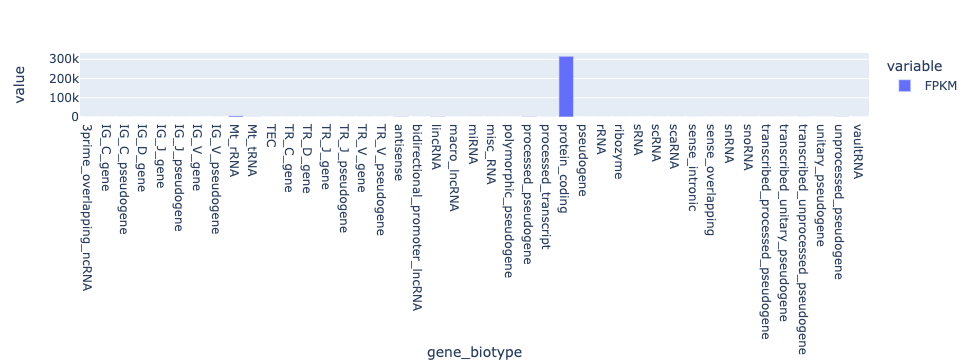

In [60]:
df_joined_on_gene_id.groupby("gene_biotype")["FPKM"].sum().plot(
    kind="bar", backend="plotly"
)

## appendix: also tried joining on gene id AND version, but this was signif worse

In [50]:
df_joined_on_gene_id_and_version = pd.merge(
    df, gene_id_names, how="left", on="gene_id_and_version"
)
df_joined_on_gene_id_and_version

,gene_id_and_version,FPKM,gene_id_x,gene_version_x,gene_biotype,gene_name,gene_id_y,gene_version_y,count_rows
0,ENSG00000242268.2,0.000000,ENSG00000242268,2,lincRNA,RP11-368I23.2,ENSG00000242268,2.0,6.0
1,ENSG00000270112.3,0.000000,ENSG00000270112,3,processed_transcript,RP11-742D12.2,ENSG00000270112,3.0,9.0
2,ENSG00000167578.15,6.891068,ENSG00000167578,15,NaN,NaN,NaN,NaN,NaN
3,ENSG00000273842.1,0.000000,ENSG00000273842,1,NaN,NaN,NaN,NaN,NaN
4,ENSG00000078237.5,8.628685,ENSG00000078237,5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
60478,ENSG00000105063.17,17.687587,ENSG00000105063,17,NaN,NaN,NaN,NaN,NaN
60479,ENSG00000231119.2,0.082573,ENSG00000231119,2,antisense,RP4-569M23.2,ENSG00000231119,2.0,4.0
60480,ENSG00000280861.1,0.000000,ENSG00000280861,1,NaN,NaN,NaN,NaN,NaN
60481,ENSG00000123685.7,1.328293,ENSG00000123685,7,NaN,NaN,NaN,NaN,NaN
